In [119]:
from preprocess import Preprocessing
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from evaluation import get_results, get_cross_validation_scores, save_results_to_csv, plot_parameter_sensitivity
from scipy.stats import loguniform
import pandas as pd
import matplotlib.pylab as plt
from sklearn.metrics import classification_report
import time
import numpy as np

In [120]:
# df to save random search times
index_name = 'model_name'
column_name = 'randsearch_time'

df_times = pd.DataFrame(
    index = pd.Index([], name=index_name),
    columns = [column_name],
    dtype = np.float64
)

## Base model

              precision    recall  f1-score   support

   False (0)       0.97      0.94      0.96        35
    True (1)       0.91      0.95      0.93        22

    accuracy                           0.95        57
   macro avg       0.94      0.95      0.94        57
weighted avg       0.95      0.95      0.95        57



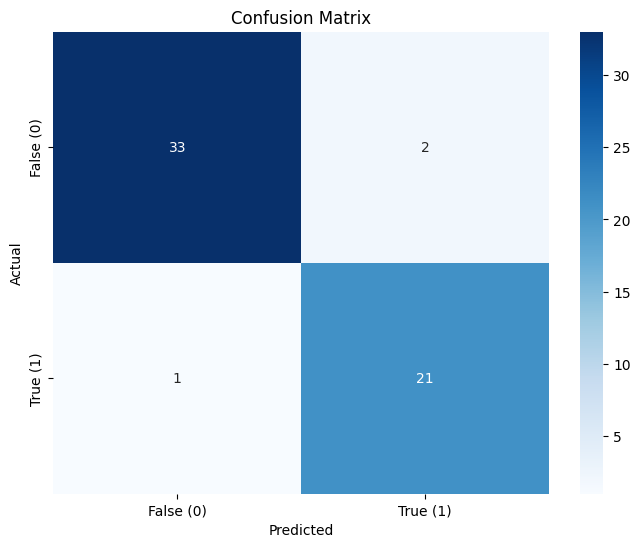

In [ ]:
# Create train and test split
pp = Preprocessing()
df = pp.load_data()
# Set ridge to true, so the labels are mapped correctly
X_train, X_test, y_train, y_test = pp.preprocess_data(df, ridge=True)

# Get feature and target names
temp_df = df.drop(['ID', 'class'], axis=1)
feature_names = temp_df.columns.tolist()
target_names = ['False (0)', 'True (1)']

ridge_model = RidgeClassifier(class_weight= 'balanced',random_state=42)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)

get_results(y_test, y_pred_ridge, target_names)

## Base model without estimating intercept

              precision    recall  f1-score   support

   False (0)       0.96      0.74      0.84        35
    True (1)       0.70      0.95      0.81        22

    accuracy                           0.82        57
   macro avg       0.83      0.85      0.82        57
weighted avg       0.86      0.82      0.83        57



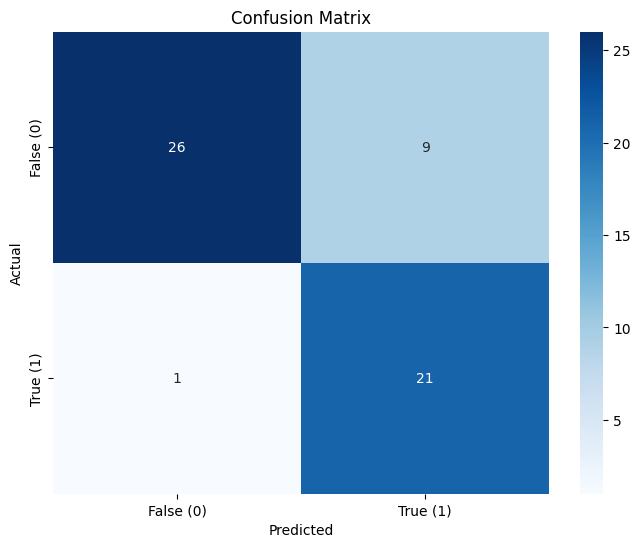

In [ ]:
ridge_model_nointercept = RidgeClassifier(class_weight= 'balanced', fit_intercept= False, random_state=42)
ridge_model_nointercept.fit(X_train, y_train)

y_pred_ridge = ridge_model_nointercept.predict(X_test)

get_results(y_test, y_pred_ridge, target_names)

## Base model cross-val scores and hyperparam optimalization

In [123]:
get_cross_validation_scores(ridge_model, X_train, y_train )

10-Fold CV Scores: [0.91304348 0.95577373 1.         0.95686075 0.95599259 0.95599259
 0.95599259 0.8121118  0.953814   0.9550406 ]
Average f1_weighted Score: 0.9415
Standard Deviation: 0.0473


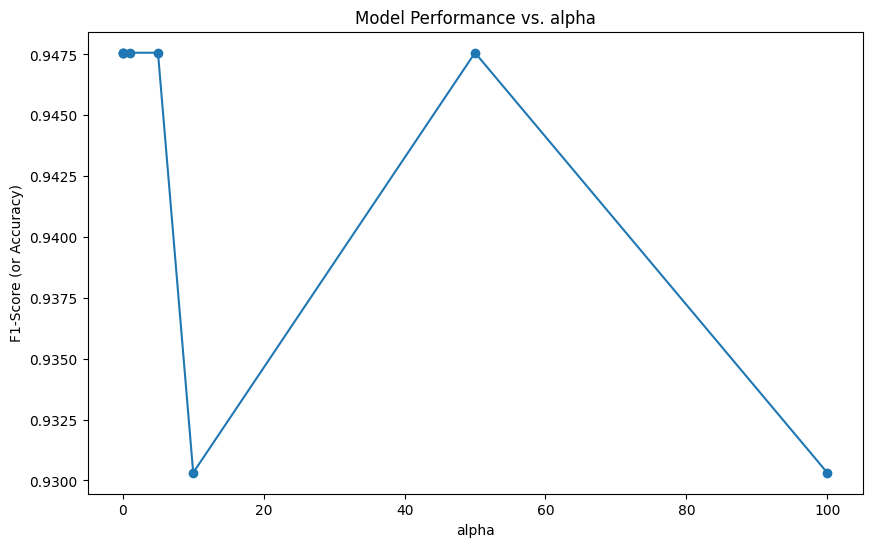

Alpha Values Tested: [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 50.0, 100.0]
Weighted F1 Scores: ['0.9476', '0.9476', '0.9476', '0.9476', '0.9476', '0.9303', '0.9476', '0.9303']


In [124]:
f1_scores_ridge = []
param_range = [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 50.0, 100.0]
# 2. Iterate through the alpha values
for alpha_val in param_range:
    # Instantiate the RidgeClassifier with the current alpha
    ridge_exp = RidgeClassifier(
        alpha=alpha_val,  # Set the current alpha value
        class_weight='balanced',
        random_state=42
    )
    
    # Train the model
    ridge_exp.fit(X_train, y_train)
    
    # Generate the classification report
    report = classification_report(
        y_test, 
        ridge_exp.predict(X_test), 
        output_dict=True
    )
    
    # Store the weighted F1-score
    f1_scores_ridge.append(report['weighted avg']['f1-score'])

# 3. Plot the results
# The plotting logic is simpler for Ridge as there's no 'None' value
plot_parameter_sensitivity(
    param_values=param_range, 
    scores=f1_scores_ridge, 
    param_name="alpha"
)

# Optional: Print results
print("Alpha Values Tested:", param_range)
print("Weighted F1 Scores:", [f"{score:.4f}" for score in f1_scores_ridge])

In [125]:
model_name = 'ridge_weights'

# Parameters to optimize
param_distributions = {
    'alpha': loguniform(1e-3, 1),
}


random_search = RandomizedSearchCV(
    estimator=ridge_model,
    param_distributions=param_distributions,
    n_iter=50,  
    cv=5,     
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

df_times.loc[model_name, column_name] = training_time
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best F1-score: {random_search.best_score_:.4f}")

final_model = random_search.best_estimator_

Best parameters found: {'alpha': np.float64(0.013292918943162165)}
Best F1-score: 0.9464


Optimal alpha found: 0.013292918943162165

              precision    recall  f1-score   support

   False (0)       0.97      0.94      0.96        35
    True (1)       0.91      0.95      0.93        22

    accuracy                           0.95        57
   macro avg       0.94      0.95      0.94        57
weighted avg       0.95      0.95      0.95        57



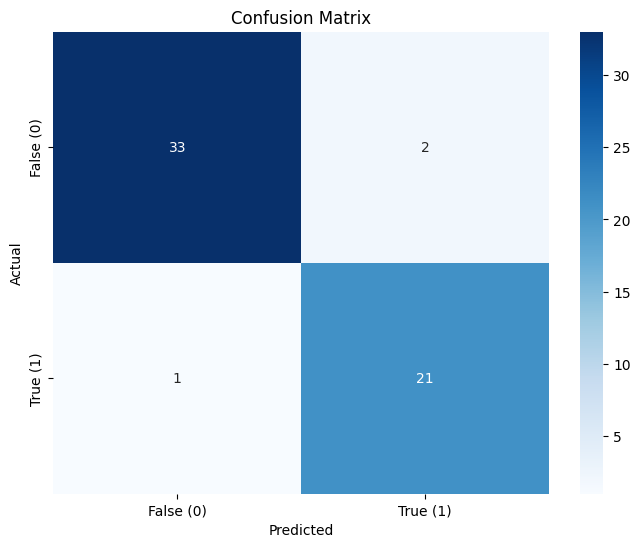

In [126]:
y_pred_ridge_opt = final_model.predict(X_test)
get_results(y_test, y_pred_ridge_opt, target_names)

In [127]:
test_data_path = 'data/breast-cancer-diagnostic.shuf.tes.csv'
save_results_to_csv(final_model, pp, test_data_path, 'preds_ridge.csv', ridge=True)

Performance on the kaggle test set: 0.96428

## Base model without balanced weights

              precision    recall  f1-score   support

   False (0)       0.97      0.94      0.96        35
    True (1)       0.91      0.95      0.93        22

    accuracy                           0.95        57
   macro avg       0.94      0.95      0.94        57
weighted avg       0.95      0.95      0.95        57



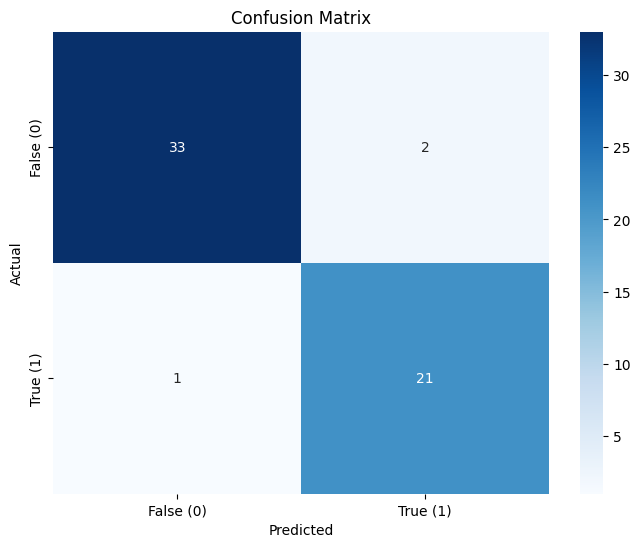

In [128]:
ridge_model_noweights = RidgeClassifier(random_state=42)
ridge_model_noweights.fit(X_train, y_train)

y_pred_ridge = ridge_model_noweights.predict(X_test)

get_results(y_test, y_pred_ridge, target_names)

In [129]:
get_cross_validation_scores(ridge_model_noweights, X_train, y_train )

10-Fold CV Scores: [0.95577373 0.95577373 1.         0.95686075 0.95599259 1.
 0.95599259 0.8121118  0.953814   1.        ]
Average f1_weighted Score: 0.9546
Standard Deviation: 0.0515


In [130]:
model_name = 'ridge_noweights'

# Parameters to optimize
param_distributions = {
    'alpha': loguniform(1e-3, 1),
}


random_search = RandomizedSearchCV(
    estimator=ridge_model_noweights,
    param_distributions=param_distributions,
    n_iter=50,  
    cv=5,     
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
df_times.loc[model_name, column_name] = training_time

print(f"Best parameters found: {random_search.best_params_}")
print(f"Best F1-score: {random_search.best_score_:.4f}")

final_model = random_search.best_estimator_

Best parameters found: {'alpha': np.float64(0.711447600934342)}
Best F1-score: 0.9503


              precision    recall  f1-score   support

   False (0)       0.97      0.94      0.96        35
    True (1)       0.91      0.95      0.93        22

    accuracy                           0.95        57
   macro avg       0.94      0.95      0.94        57
weighted avg       0.95      0.95      0.95        57



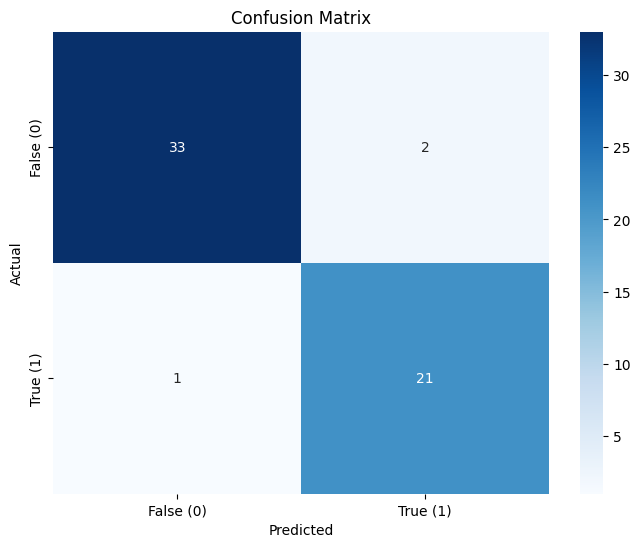

In [131]:
y_pred_ridge_opt = final_model.predict(X_test)
get_results(y_test, y_pred_ridge_opt, target_names)

In [132]:
save_results_to_csv(final_model, pp, test_data_path, 'preds_ridge_noweights.csv', ridge=True)

Performance on the kaggle test set:
0.90566

## Unscaled data

              precision    recall  f1-score   support

   False (0)       0.97      0.94      0.96        35
    True (1)       0.91      0.95      0.93        22

    accuracy                           0.95        57
   macro avg       0.94      0.95      0.94        57
weighted avg       0.95      0.95      0.95        57



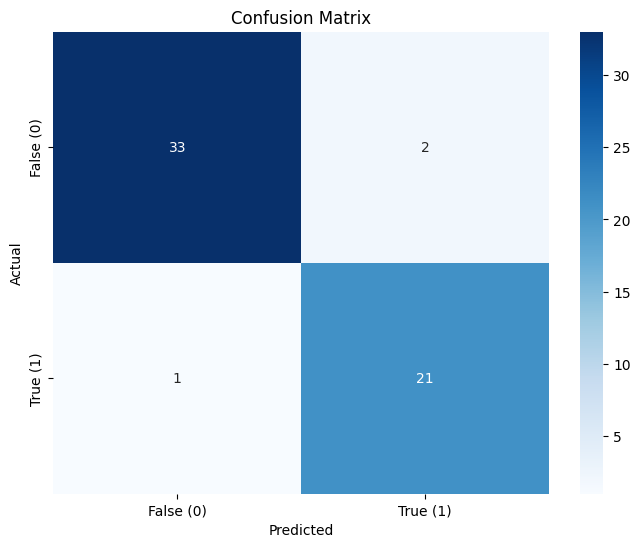

In [133]:
# Create train and test split
pp = Preprocessing()
df = pp.load_data()
X_train, X_test, y_train, y_test = pp.preprocess_data(df, ridge=True, scale=False)

# Get feature and target names
temp_df = df.drop(['ID', 'class'], axis=1)
feature_names = temp_df.columns.tolist()
target_names = ['False (0)', 'True (1)']

ridge_model = RidgeClassifier(class_weight='balanced',random_state=42)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)

get_results(y_test, y_pred_ridge, target_names)

In [134]:
model_name = 'ridge_unscaled'

# Parameters to optimize
param_distributions = {
    'alpha': loguniform(1e-3, 1),
}


random_search = RandomizedSearchCV(
    estimator=ridge_model,
    param_distributions=param_distributions,
    n_iter=50,  
    cv=5,     
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
df_times.loc[model_name, column_name] = training_time

print(f"Best parameters found: {random_search.best_params_}")
print(f"Best F1-score: {random_search.best_score_:.4f}")

final_model = random_search.best_estimator_

Best parameters found: {'alpha': np.float64(0.7886714129990487)}
Best F1-score: 0.9554


              precision    recall  f1-score   support

   False (0)       0.97      0.94      0.96        35
    True (1)       0.91      0.95      0.93        22

    accuracy                           0.95        57
   macro avg       0.94      0.95      0.94        57
weighted avg       0.95      0.95      0.95        57



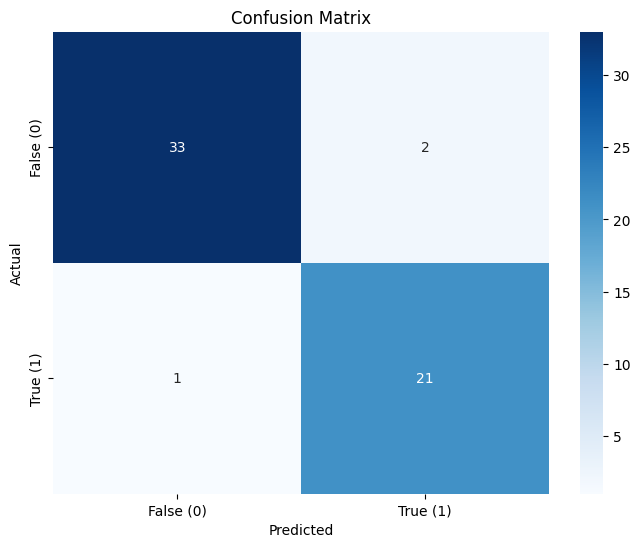

In [135]:
y_pred_ridge_opt = final_model.predict(X_test)
get_results(y_test, y_pred_ridge_opt, target_names)

In [136]:
save_results_to_csv(final_model, pp, test_data_path, 'preds_ridge_noscaling.csv', scaled = False, ridge=True)

Results on the kaggle test set: 0.90909

In [ ]:
# Save the randomsearch times
df_times.to_csv('randsearch_times_ridge.csv')